In [63]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import srsly
from datasets import load_from_disk
from matplotlib import ticker
from scipy.special import entr, softmax
from sklearn.manifold import TSNE
from tqdm.auto import tqdm

---
## Full data

In [64]:
path_to_experiments = Path("../outputs/multirun/full_data/")

In [67]:
list_dfs = []
for dataset in path_to_experiments.iterdir():
    for run in dataset.iterdir():
        if not run.is_dir():
            continue
        df = pd.DataFrame(srsly.read_jsonl(run / "logs" / "test" / "epoch_level.jsonl")).assign(
            dataset=dataset.name
        )
        list_dfs.append(df)

In [69]:
df = pd.concat(list_dfs)

In [74]:
df.groupby("dataset").agg(["mean", "std"], numeric_only=True)

/tmp/ipykernel_2520241/317064443.py:1: FutureWarning: ['stage'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("dataset").agg(["mean", "std"], numeric_only=True)


epoch           loss            accuracy  \
                                      mean  std      mean       std      mean   
dataset                                                                         
agnews_bert_tiny_2023-03-04T15-36-30   0.0  0.0  0.227895  0.004987  0.927928   
imdb_bert_tiny_2023-03-04T15-38-25     0.0  0.0  0.296026  0.007633  0.880460   

                                                f1_macro            f1_micro  \
                                           std      mean       std      mean   
dataset                                                                        
agnews_bert_tiny_2023-03-04T15-36-30  0.001899  0.927846  0.001986  0.927928   
imdb_bert_tiny_2023-03-04T15-38-25    0.001099  0.880452  0.001109  0.880460   

                                               precision_macro            \
                                           std            mean       std   
dataset                                                                    
agnews_bert_tiny_2023-03-04T15-36-30  0.001899        0.928159  0.001921   
imdb_bert_tiny_2023-03-04T15-38-25    0.001099        0.880518  0.001023   

                                     precision_micro           recall_macro  \
                                                mean       std         mean   
dataset                                                                       
agnews_bert_tiny_2023-03-04T15-36-30        0.927928  0.001899     0.927928   
imdb_bert_tiny_2023-03-04T15-38-25          0.880460  0.001099     0.880462   

                                               recall_micro            
                                           std         mean       std  
dataset                                                                
agnews_bert_tiny_2023-03-04T15-36-30  0.001899     0.927928  0.001899  
imdb_bert_tiny_2023-03-04T15-38-25    0.001119     0.880460  0.001099

---
## Active learning

In [20]:
path_to_experiment = Path("../outputs/multirun/reinit_effect/patch")
path_to_experiment

PosixPath('../outputs/multirun/reinit_effect/patch')

In [ ]:
path_to_experiment = Path("../outputs/multirun/reinit_effect/patch")

---

### T-SNE

In [ ]:
embeddings = np.load(f"../data/processed/agnews/ag_news_index.npy")
sample = embeddings[np.random.randint(0, 1, size=10_000)]
t_sne = TSNE(
    n_components=2,
    perplexity=100,
    init="random",
    n_iter=500,
    random_state=0,
    verbose=1,
)
S_t_sne = t_sne.fit_transform(embeddings)
plt.scatter(S_t_sne[:, 0], S_t_sne[:, 1])

### Plots

In [ ]:
data = []

for dataset in path_to_experiment.iterdir():
    for strategy in dataset.iterdir():
        for reinit in strategy.iterdir():
            for run in reinit.iterdir():
                data_seed, model_seed = run.name.split("_")
                results = pd.DataFrame(
                    srsly.read_jsonl(run / "logs" / "test" / "epoch_level.jsonl")
                ).assign(
                    data_seed=int(data_seed.split("=")[1]),
                    model_seed=int(model_seed.split("=")[1]),
                    dataset=dataset.name,
                    strategy=strategy.name,
                    reinit=eval(str(reinit.name).split("=")[-1]),
                )
                data.append(results)

In [ ]:
df = pd.concat(data)
df

In [21]:
df.groupby(["strategy", "reinit", "dataset"])[["data_seed", "model_seed"]].size()

strategy           reinit  dataset
entropy            False   agnews     400
                           imdb       368
                   True    agnews     400
                           imdb       368
margin_confidence  False   agnews     400
                           imdb         5
                   True    agnews     400
                           imdb       136
random             False   agnews     400
                           imdb       400
                   True    agnews     400
                           imdb       400
dtype: int64

In [ ]:
df_agg = (
    df.groupby(["dataset", "strategy", "reinit", "round"])[
        ["accuracy", "f1_macro", "precision_macro", "recall_macro"]
    ]
    .agg(["mean", "std", "min", "max"])
    .stack(0)
    .reset_index()
    .rename(columns={"level_4": "metric"})
)

In [ ]:
df_agg

In [ ]:
plot_data = df_agg.loc[(df_agg["dataset"] == "imdb") & (df_agg["metric"] == "f1_macro")].rename(
    columns={"reinit": "re-initialise"}
)
plot_data

In [ ]:
sns.diverging_palette(250, 30, l=65, center="dark", n=3)

In [ ]:
def plot(plot_data, dpi, ymin, hline, title, metric):
    # colors = sns.color_palette("Spectral", n_colors=len(plot_data["strategy"].unique()))
    colors = sns.diverging_palette(250, 30, l=65, center="dark", n=plot_data["strategy"].nunique())

    # sns.set_style("white", rc={"xtick.bottom" : True, "ytick.left" : True})
    plt.style.use("bmh")
    sns.set_context("paper")

    # plot
    fig, ax = plt.subplots()
    fig.dpi = dpi

    sns.lineplot(
        data=plot_data,
        x="round",
        y="mean",
        hue="strategy",
        style="re-initialise",
        palette=colors,
        ax=ax,
    )

    # fill area between min and max for each group
    for group1, group1_data in plot_data.groupby("strategy"):
        group_color = colors[plot_data["strategy"].unique().tolist().index(group1)]

        for _, group2_data in group1_data.groupby("re-initialise"):
            group2_data

            ax.fill_between(
                group2_data["round"],
                group2_data["min"],
                group2_data["max"],
                alpha=0.2,
                color=group_color,
            )

    # add 90% line
    ax.hlines(hline, *plt.xlim(), colors="red")

    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.set_xlim(0, 100)
    ax.set_ylim(ymin)

    fig.suptitle(title)
    ax.set_title("(25 instances per round, 10 assigned to validation)", fontsize=10)
    ax.set_ylabel(metric)
    ax.set_xlabel("Labelling round")
    ax.legend(fontsize=10, bbox_to_anchor=(1, 1))

    sns.despine()
    plt.show()

In [75]:
for dataset in ("agnews", "imdb"):
    if dataset == "imdb":
        continue
    for metric in ("f1_macro", "accuracy"):
        plot_data = df_agg.loc[
            (df_agg["dataset"] == dataset) & (df_agg["metric"] == metric)
        ].rename(columns={"reinit": "re-initialise"})
        plot(
            plot_data,
            800,
            0.5 if dataset == "imdb" else 0.75,
            0.85 if dataset == "imdb" else 0.9,
            dataset.upper(),
            metric.title().replace("_", "-"),
        )

KeyError: 'metric'

---

### Cartography

In [22]:
dataset = "agnews"
strategy = "entropy"

In [23]:
original_df = load_from_disk(f"../data/processed/{dataset}/")["train"].to_pandas()

/home/pl487/.conda/envs/anchoral/lib/python3.9/site-packages/datasets/dataset_dict.py:1241: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [24]:
paths = list((path_to_experiment / dataset).iterdir())
paths

[PosixPath('../outputs/multirun/reinit_effect/patch/agnews/margin_confidence'),
 PosixPath('../outputs/multirun/reinit_effect/patch/agnews/entropy'),
 PosixPath('../outputs/multirun/reinit_effect/patch/agnews/random')]

In [26]:
data = []
stage = "pool"

list_df = []
for dataset in tqdm(list(path_to_experiment.iterdir())):
    if dataset.name == "imdb":
        continue
    original_df = load_from_disk(f"../data/processed/{dataset.name}/")["train"].to_pandas()
    for strategy in tqdm(list(dataset.iterdir())):
        if strategy.name == "random":
            continue
        for reinit in tqdm(list(strategy.iterdir())):
            for run in tqdm(list(reinit.iterdir())):
                data_seed, model_seed = run.name.split("_")

                df = pd.concat(
                    [
                        pd.read_csv(i).assign(stage=stage)
                        for i in (run / "logs" / stage).glob("*csv")
                    ]
                )

                # add labels
                df = pd.merge(
                    df,
                    original_df[["unique_id", "labels"]],
                    on="unique_id",
                    how="left",
                )

                # add logits and margin
                logits = df.iloc[:, df.columns.str.startswith("logit")].values
                probs = softmax(logits, axis=1)
                sorted_probs = np.take_along_axis(probs, probs.argsort(-1), axis=1)
                df = df.assign(
                    entropy=entr(probs).sum(-1),
                    margin=sorted_probs[:, -1] - sorted_probs[:, -2],
                    preds=probs.argmax(-1),
                    prob_pred=probs.max(-1),
                    prob_true=lambda df_: np.take_along_axis(
                        probs, df_["labels"].values.reshape(-1, 1), axis=1
                    ),
                )

                # aggregate
                df_agg = (
                    df.groupby("round")[["entropy", "margin", "prob_pred", "prob_true"]]
                    .agg(["mean", "max", "min", "std", "size"])
                    .assign(
                        data_seed=int(data_seed.split("=")[1]),
                        model_seed=int(model_seed.split("=")[1]),
                        dataset=dataset.name,
                        strategy=strategy.name,
                        reinit=eval(str(reinit.name).split("=")[-1]),
                    )
                )

                list_df.append(df_agg)

  0%|          | 0/2 [00:00<?, ?it/s]

/home/pl487/.conda/envs/anchoral/lib/python3.9/site-packages/datasets/dataset_dict.py:1241: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [29]:
agnews = pd.concat(list_df).reset_index()
agnews

round   entropy                                          margin  \
                mean       max       min       std    size      mean   
0        0  1.345156  1.386288  1.246575  0.020837  119900  0.093261   
1        1  1.238897  1.386105  1.071700  0.068917  119875  0.197176   
2        2  0.660242  1.381409  0.401766  0.218096  119850  0.660181   
3        3  1.313764  1.386287  1.206977  0.032512  119825  0.126493   
4        4  1.071028  1.385984  0.880400  0.103002  119800  0.371453   
...    ...       ...       ...       ...       ...     ...       ...   
1595    95  0.043686  1.369069  0.002529  0.140392  117525  0.970846   
1596    96  0.044478  1.375025  0.002372  0.141967  117500  0.970015   
1597    97  0.041132  1.373965  0.002305  0.137721  117475  0.972166   
1598    98  0.043669  1.359883  0.002020  0.143786  117450  0.970795   
1599    99  0.036511  1.343246  0.001766  0.130056  117425  0.974753   

                                        ... prob_true                      \
           max           min       std  ...      mean       max       min   
0     0.310907  1.126797e-08  0.060837  ...  0.336130  0.494945  0.135719   
1     0.457235  3.427092e-06  0.114664  ...  0.419189  0.616606  0.075252   
2     0.866518  2.649361e-05  0.231106  ...  0.691702  0.908388  0.015312   
3     0.338320  6.139791e-06  0.075013  ...  0.370904  0.521894  0.117026   
4     0.605891  3.721954e-06  0.163758  ...  0.536823  0.723840  0.044256   
...        ...           ...       ...  ...       ...       ...       ...   
1595  0.999667  2.985034e-04  0.122107  ...  0.864811  0.999757  0.000048   
1596  0.999691  2.270916e-04  0.124355  ...  0.864510  0.999774  0.000047   
1597  0.999696  5.125916e-05  0.119731  ...  0.867250  0.999780  0.000045   
1598  0.999742  7.661923e-05  0.122713  ...  0.866897  0.999811  0.000037   
1599  0.999778  5.447691e-04  0.114793  ...  0.868769  0.999837  0.000033   

                       data_seed model_seed dataset           strategy reinit  
           std    size                                                         
0     0.060180  119900         0          0  agnews  margin_confidence   True  
1     0.116389  119875         0          0  agnews  margin_confidence   True  
2     0.275181  119850         0          0  agnews  margin_confidence   True  
3     0.071256  119825         0          0  agnews  margin_confidence   True  
4     0.167294  119800         0          0  agnews  margin_confidence   True  
...        ...     ...       ...        ...     ...                ...    ...  
1595  0.326680  117525      1994       1994  agnews            entropy  False  
1596  0.326573  117500      1994       1994  agnews            entropy  False  
1597  0.324676  117475      1994       1994  agnews            entropy  False  
1598  0.324366  117450      1994       1994  agnews            entropy  False  
1599  0.324444  117425      1994       1994  agnews            entropy  False  

[1600 rows x 26 columns]

In [97]:
plot_data = (
    agnews.set_index(["round", "strategy", "reinit"])
    .drop(columns=["data_seed", "model_seed", "dataset"])
    .stack(0)
    .reset_index()
    .rename(columns={"level_3": "metric", "reinit": "re-initialise"})
    .rename(columns={})
    .sort_values("strategy")
)

In [98]:
plot_data

,round,strategy,re-initialise,metric,max,mean,min,size,std
6399,99,entropy,False,prob_true,0.999837,0.868769,0.000033,117425,0.324444
4271,67,entropy,True,prob_true,0.680435,0.505251,0.059708,118225,0.129114
4270,67,entropy,True,prob_pred,0.680435,0.537497,0.252994,118225,0.082103
4269,67,entropy,True,margin,0.564907,0.316707,0.000019,118225,0.141991
4268,67,entropy,True,entropy,1.386238,1.152378,0.971853,118225,0.079732
...,...,...,...,...,...,...,...,...,...
2128,32,margin_confidence,False,entropy,1.349504,0.081092,0.007301,119100,0.183397
2127,31,margin_confidence,False,prob_true,0.999151,0.856376,0.000136,119125,0.315230
2126,31,margin_confidence,False,prob_pred,0.999151,0.962689,0.309537,119125,0.097418
2124,31,margin_confidence,False,entropy,1.352036,0.109447,0.007752,119125,0.213362


In [99]:
sns.diverging_palette(250, 30, l=65, center="dark", n=3)

[(0.4265534711840377, 0.6260975213663689, 0.9072715683943962),
 (0.14918455888545099, 0.1381228160190642, 0.13476544093324597),
 (0.90499399934908, 0.5182704637470051, 0.3064196349089693)]

In [100]:
def plot(plot_data, dpi, ymin, title, metric, y):
    colors = sns.diverging_palette(250, 30, l=65, center="dark", n=3)

    plt.style.use("bmh")
    sns.set_context("paper")

    # plot
    fig, ax = plt.subplots()
    fig.dpi = dpi

    sns.lineplot(
        data=plot_data.loc[(plot_data["metric"] == metric)],
        x="round",
        y=y,
        hue="strategy",
        style="re-initialise",
        ax=ax,
        palette=colors,
    )

    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
    # ax.set_xlim(0, 100)
    ax.set_ylim(ymin)

    fig.suptitle(title)
    ax.set_title(f"average {y} {metric} on the entire pool across rounds", fontsize=10)
    ax.set_ylabel(metric)
    ax.set_xlabel("Labelling round")
    ax.legend(fontsize=10, bbox_to_anchor=(1, 1))

    sns.despine()
    plt.show()

/tmp/ipykernel_2520241/3708231446.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(data=plot_data.loc[(plot_data["metric"] == metric)], x="round", y=y, hue="strategy", style="re-initialise", ax=ax, palette=colors)


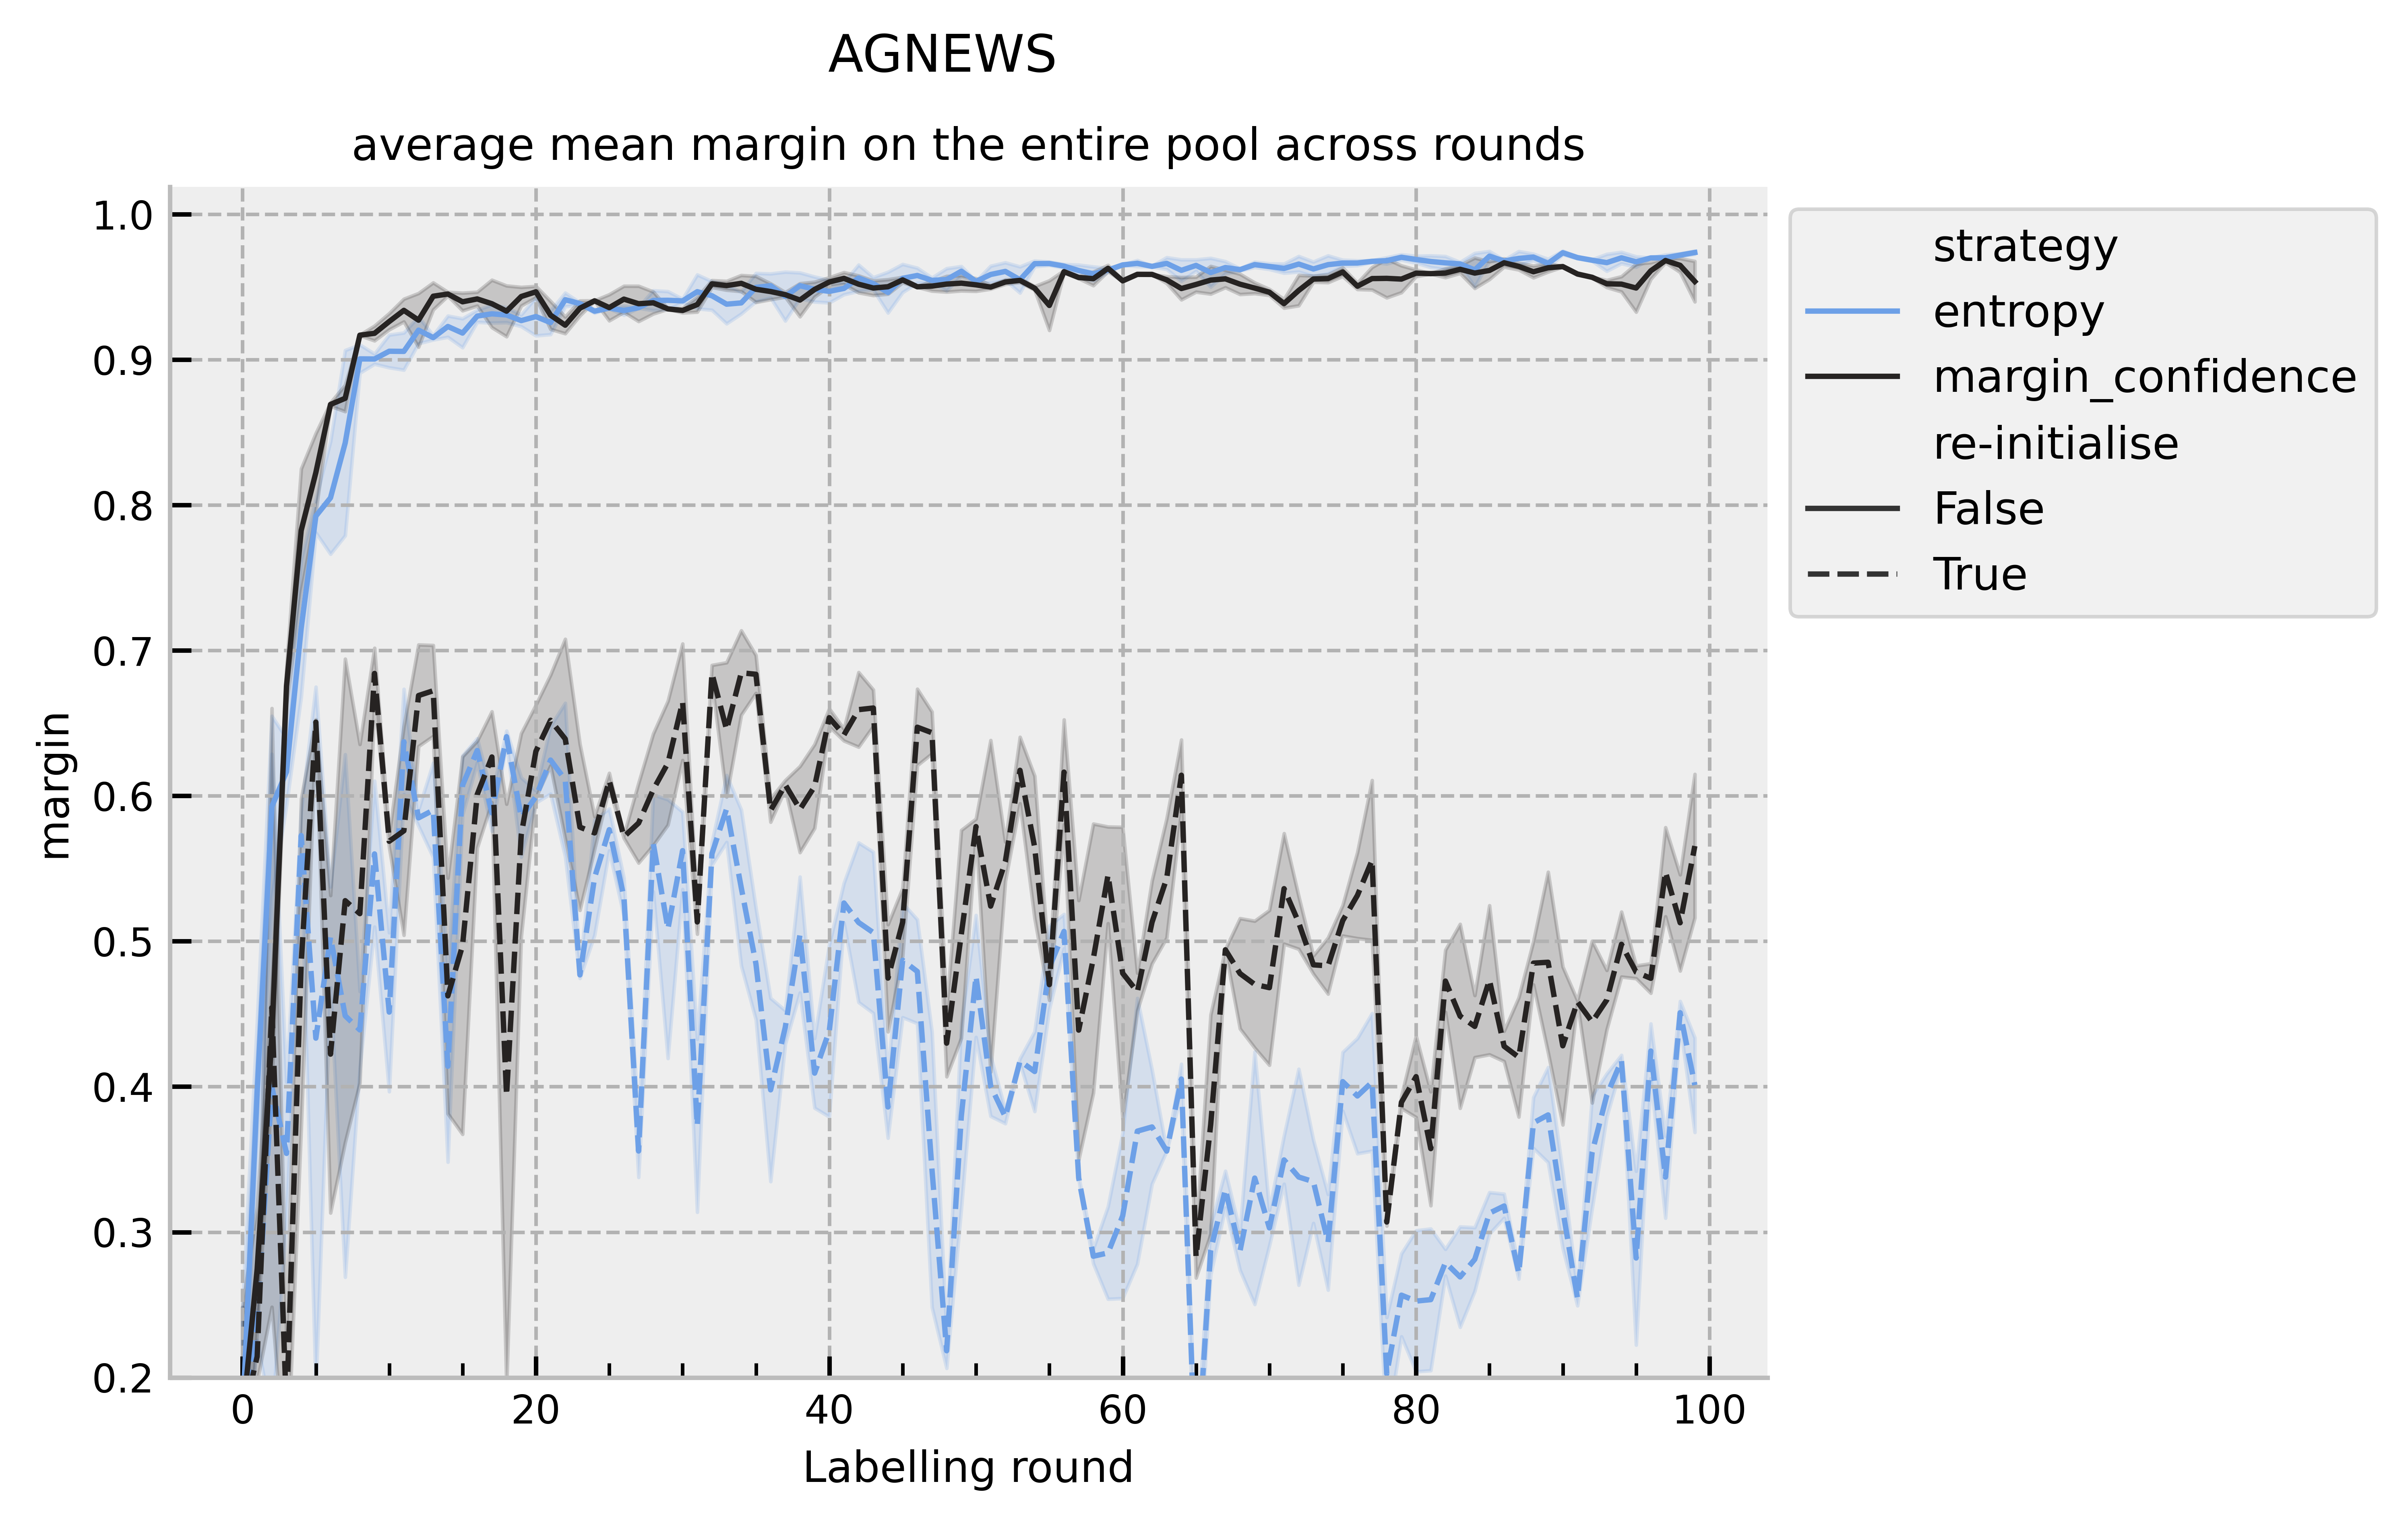

In [107]:
plot(plot_data, dpi=800, ymin=0.2, title="AGNEWS", metric="margin", y="mean")

In [57]:
import joypy

In [58]:
p = plot_data.loc[
    (plot_data["metric"] == "margin")
    & (plot_data["strategy"] == "entropy")
    & (plot_data["re-initialise"] == True)
]

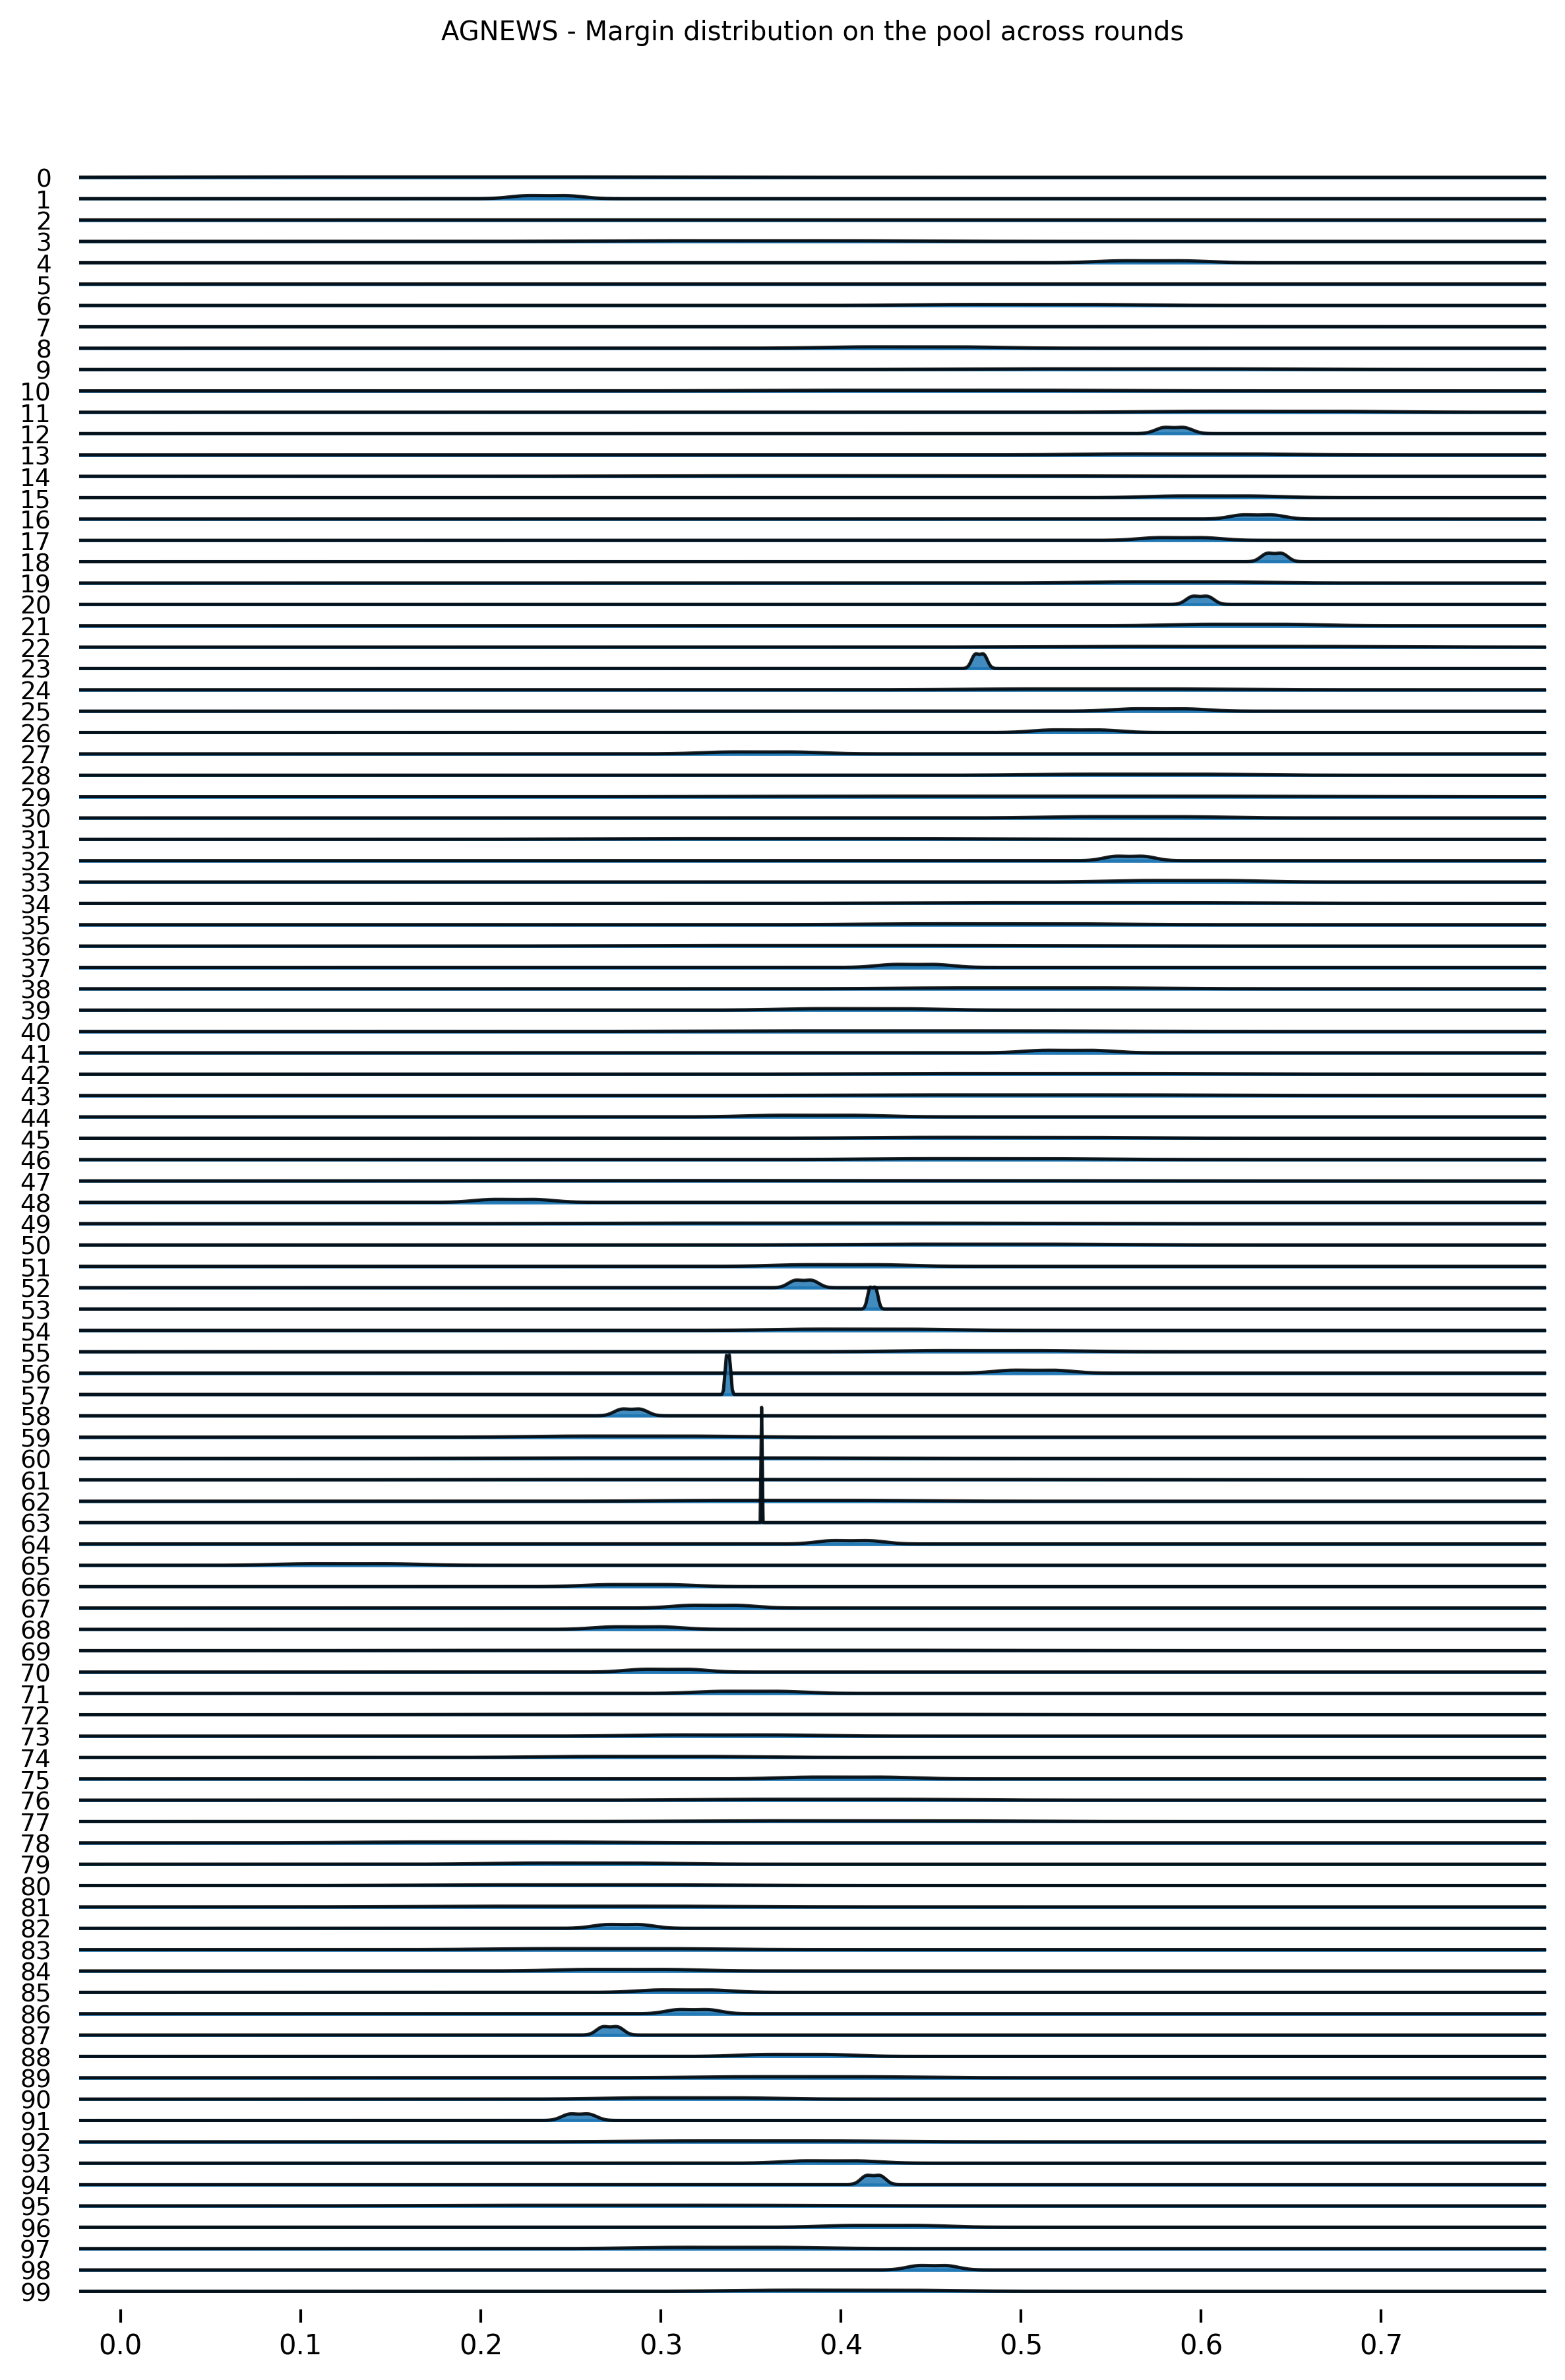

In [61]:
plt.style.use("default")
sns.set_context("paper")
fig, ax = joypy.joyplot(
    data=p[["mean", "round"]],
    by="round",
    figsize=(8, 12),
    alpha=0.85,
    ylabelsize=9,
    xlabelsize=10,
)
fig.dpi = 300
plt.title("AGNEWS - Margin distribution on the pool across rounds")
plt.show()

In [ ]:
plt.style.use("default")
sns.set_context("paper")
fig, ax = joypy.joyplot(
    data=a[["entropy", "epoch"]],
    by="epoch",
    figsize=(8, 12),
    alpha=0.85,
    ylabelsize=9,
    xlabelsize=10,
)
fig.dpi = 300
plt.title("AGNEWS - Entropy distribution on the pool across rounds")
plt.show()

In [ ]:
plt.style.use("default")
sns.set_context("paper")
fig, ax = joypy.joyplot(
    data=a[["prob_correct", "epoch"]],
    by="epoch",
    figsize=(8, 12),
    alpha=0.85,
    ylabelsize=9,
    xlabelsize=10,
)
fig.dpi = 300
plt.title("AGNEWS - Probability of being correct across rounds")
plt.show()

In [ ]:
df_agg = df.groupby(["unique_id"])[["correct", "entropy", "margin", "prob_correct", "queried"]].agg(
    ["mean", "std", "size", "sum"]
)

In [ ]:
df_agg = df_agg.drop(columns=["correct", "queried"]).assign(
    correct=df_agg["correct"]["sum"], queried=df_agg["queried"]["mean"] < 1
)

In [ ]:
df_agg = df_agg.set_index(["correct", "queried"], append=True)

In [ ]:
df_agg = df_agg.stack(0).reset_index().rename(columns={"level_3": "metric"})

In [ ]:
df_agg = df_agg.drop(columns=["sum"])

In [ ]:
df_agg["correct_weighted"] = df_agg["correct"] / df_agg["size"]

In [ ]:
df_agg = df_agg.rename(
    columns={
        "correct_weighted": "correctly predicted (prop.)",
        "size": "num. times seen",
    }
)

In [ ]:
def plot(plot_data, dpi, title, metric):
    colors = sns.color_palette("viridis", as_cmap=True)

    plt.style.use("bmh")
    sns.set_context("paper")

    # plot
    fig, ax = plt.subplots()
    fig.dpi = dpi

    # sns.scatterplot(plot_data, x="std", y="mean", hue="correctly predicted (prop.)", size="num. times seen", ax=ax, palette=colors, alpha=0.5, sizes=(1, 100))
    sns.scatterplot(
        plot_data,
        x="std",
        y="mean",
        hue="correctly predicted (prop.)",
        ax=ax,
        palette=colors,
        alpha=0.5,
    )

    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))

    fig.suptitle(title)
    ax.set_title("(averaged across epochs and labelling rounds)", fontsize=10)
    ax.set_ylabel(metric)
    ax.set_xlabel("std")
    ax.legend(fontsize=10, bbox_to_anchor=(1, 1))

    sns.despine()
    plt.show()

In [ ]:
plot_data = df_agg.loc[df_agg["metric"] == "prob_correct"]
plot(
    plot_data,
    dpi=800,
    title="IMDB - Entropy strategy without re-initialization",
    metric="average probability of the correct class",
)

In [ ]:
plot_data = df_agg.loc[(df_agg["metric"] == "entropy") & (df_agg["queried"] == False)]
plot(
    plot_data,
    dpi=300,
    title="IMDB - Entropy strategy without re-initialization",
    metric="average entropy",
)

In [ ]:
plot_data = df_agg.loc[(df_agg["metric"] == "margin") & (df_agg["queried"] == False)]
plot(
    plot_data,
    dpi=800,
    title="IMDB - Entropy strategy with re-initialization",
    metric="average margin",
)

In [ ]:
plot_data.loc[plot_data["queried"] == False]

In [ ]:
import os
import shutil
from pathlib import Path

In [ ]:
path = Path("../outputs/multirun/reinit_effect/")

In [ ]:
s_path = list(path.glob("imdb*random*"))[0]
s_path

In [ ]:
# for i in list(s_path.rglob("+*")):
#     # shutil.rmtree(i)
#     for j in i.iterdir():
#         dest = i.parents[1] / i.parents[0].name / j.name
#         # shutil.move(j, dest)
#         print(dest)

In [ ]:
for i in s_path.iterdir():
    if not "+" in str(i):
        continue
    base_path, reinit, data_seed, _, _, model_seed, strategy, *_ = str(i).split(",")
    base_path = Path(base_path.split("+")[0])
    reinit = reinit.split(".")[1]

    new_path = base_path / reinit / f"{data_seed}_{model_seed}"
    for j in i.iterdir():
        dest = new_path / j.name
        # print(j)
        # print(dest)
        shutil.move(j, dest)

In [ ]:
import pandas as pd
import srsly
from datasets import load_from_disk

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
import torch
from scipy.special import entr, softmax
from scipy.stats import entropy
from torch.special import entr as tentr

In [ ]:
labelled_df = pd.read_parquet(
    "../outputs/small_budget/imdb_bert_tiny_2023-02-28T15-53-18/logs/labelled_dataset.parquet"
)

In [ ]:
labelled_df = labelled_df.loc[labelled_df["labelling_round"] == 0]

In [ ]:
labelled_df

In [ ]:
pool_df = pd.read_csv(
    "/home/pl487/anchoral/outputs/small_budget/imdb_bert_tiny_2023-02-28T15-53-18/logs/pool/instance_level_round=0.csv"
)

In [ ]:
cols = pool_df.columns[pool_df.columns.str.startswith("logit")].tolist()
logits = pool_df[cols].values

In [ ]:
e = entropy(logits, axis=1)
e.argsort()[::-1]

In [ ]:
e2 = entr(softmax(logits, axis=1)).sum(1)
e2.argsort()[::-1]

In [ ]:
entr(softmax(logits, axis=1)).sum(-1)

In [ ]:
logits_tensor = torch.tensor(logits)
tentr(logits_tensor.softmax(-1)).sum(-1)

In [ ]:
scores = entr(softmax(logits, axis=1)).sum(-1)

In [ ]:
scores.max()

In [ ]:
scores[scores.argsort()[::-1]]

In [ ]:
indices = scores.argsort()[::-1][:25]
ids = pool_df["unique_id"][indices]

In [ ]:
set(labelled_df["unique_id"].unique()) == set(indices)

In [ ]:
labelled_df[labelled_df["unique_id"].isin(ids)]

In [ ]:
dd = pd.merge(df, original_df, on=["unique_id", "labels"], how="inner")